# You are what you eat - Relating Demographic Data to Food Consumption Habits

In [1]:
#%matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # needed for heatmap
from os.path import join
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
import pickle
plt.rcParams['figure.figsize'] = [7, 5]

In [76]:
# define paths for data
FOLDER_PATH = 'data'
PREPROCESSED_PATH = 'preprocessed'
DATASET_NAME='df_ward_atlas.csv'
DATASET_PATH = join(FOLDER_PATH, PREPROCESSED_PATH, DATASET_NAME)

# load the data sets
df_ward_atlas=pd.read_csv(DATASET_PATH,index_col=0)
df_ward_atlas.head(1)

,weight,volume,fat,saturate,salt,sugar,protein,carb,fibre,alcohol,...,Level 1 qualifications,Level 2 qualifications,Apprenticeship qualifications,Level 3 qualifications,Level >=4 qualifications,Other qualifications,Bad Health,Limited activities,Well-Being,IOD AVG
E05000027,413.130263,110.664114,9.733634,3.565913,0.568184,10.514427,5.211694,18.950348,1.58196,0.209917,...,0.163,0.157,0.018,0.093,0.167,0.089,6.7,8.8,7.358842,1.18406


In [6]:
age_cols = ['Aged 0-15', 'Aged 16-64', 'Aged 65+'] #sum to 1
ethnicities_cols = ['White', 'Mixed', 'Asian or Asian British', 'Black or Black British', 'Other'] #sum to 1
religion_cols = ['Christian', 'Buddhist', 'Hindu', 'Jewish', 'Muslim', 'Sikh',
       'No religion', 'Other religions', 'Religion not stated'] # sum to 1
born_cols = ['Born in UK', 'Not Born in UK'] # sum to 1
wealth_cols = ['Household Income Median', 'IOD AVG', 'Well-Being']
qualilication_cols = ['No qualifications', 'Level 1 qualifications', 'Level 2 qualifications',
       'Apprenticeship qualifications', 'Level 3 qualifications',
       'Level >=4 qualifications', 'Other qualifications'] # sum to 1 
disability_cols = ['Bad Health', 'Limited activities']
all_features = age_cols + ethnicities_cols + religion_cols + born_cols + wealth_cols + qualilication_cols + disability_cols

In [23]:
def forward_feature_selection_brute_force(df_corrs_, target_col, verbose=False):
    num_features = 1
    repeat = 100
    global_test_best = 0
    selected_cols_best = None
    delay = 3
    not_improvements = 0

    df_corrs = df_corrs_.copy()
    selected_cols = []

    while (not_improvements < delay) and (len(df_corrs) > 0):
        res_train = {}
        res_test = {}
        local_train_best = 0
        local_test_best = 0
        best_new_col = None
        for new_col in df_corrs.index:
            trial_cols = selected_cols + [new_col]       
            x_data = df_ward_atlas[trial_cols]
            y_data = df_ward_atlas[target_col]
            res_train[new_col] = []
            res_test[new_col] = []
            for i in range(repeat):
                x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2)
                model = LinearRegression()
                model.fit(x_train, y_train)
                res_train[new_col].append(model.score(x_train, y_train))
                res_test[new_col].append(model.score(x_test, y_test))
            res_train[new_col] = np.array(res_train[new_col])
            res_test[new_col] = np.array(res_test[new_col])
            res_train[new_col] = np.mean(res_train[new_col])
            res_test[new_col] = np.mean(res_test[new_col])
            if (res_test[new_col] > local_test_best):
                local_test_best = res_test[new_col]
                local_train_best = res_train[new_col]
                best_new_col = new_col
        
        selected_cols.append(best_new_col)
        df_corrs.drop(best_new_col, axis=0, inplace=True)
        if (local_test_best > global_test_best):
            summary_str = 'R2 score on test data improved by {:.5}'.format(local_test_best-global_test_best)
            global_test_best = local_test_best
            selected_cols_best = selected_cols.copy()
            not_improvements = 0
        else:
            summary_str = 'R2 score on test data did not improved'
            not_improvements += 1
        if verbose:
            print('Added feature {}: {}'.format(num_features, best_new_col))
            print('Average r2_score on train data: {:.5}, on test data {:.5}'.format(local_train_best, local_test_best))
            print(summary_str + '\n')
        num_features += 1
        
    return global_test_best, selected_cols_best

In [81]:
def to_formula(cols):
    cols = list(map(lambda s: 'Q("{}")'.format(s), cols))
    return ' + '.join(cols)

def get_label_summary(label, features):
    model = smf.ols(formula='{} ~ {}'.format(label, to_formula(features)),
              data=df_ward_atlas)
    res = model.fit()
    results_as_html = res.summary().tables[1].as_html()
    df_summary=pd.read_html(results_as_html, header=0, index_col=0)[0]
    return df_summary[df_summary['P>|t|']<0.05]

def actual_name(col_in_formula):
    if col_in_formula.startswith('Q('):
        return col_in_formula[3:-2]
    else:
        return col_in_formula

In [82]:
def get_r2_samples(target, features, dataset):
    repeats = 1000
    r2_scores = []
    
    x_data = dataset[features]
    y_data = dataset[target]
    for i in range(repeats):
        x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2)
        model = LinearRegression()
        model.fit(x_train, y_train)
        r2_scores.append(model.score(x_test, y_test))
    return np.array(r2_scores)

def estimate_from_samples(samples, p_value=0.05):
    samples = np.sort(samples)
    lower_CI_pos = int(np.round(len(samples) * p_value/2))
    upper_CI_pos = int(np.round(len(samples) * (1-p_value/2)))
    estimator = np.median(samples)
    return estimator, samples[lower_CI_pos], samples[upper_CI_pos]

In [83]:
r2_scores = {}
selected_cols_very_best = {}
r2_estimators = {}
r2_lower_CIs = {}
r2_upper_CIs = {}
repres_vals = np.linspace(0.1,1,10)

# Predicting a fraction of each nutrient energy

In [87]:
target_cols = ['energy_tot', 'f_energy_fat', 'f_energy_saturate', 
                 'f_energy_sugar', 'f_energy_protein', 'f_energy_carb', 'f_energy_fibre', 
               'f_energy_alcohol']
global_test_best = {}
selected_cols_best = {}
energy_corr = {}
for y in target_cols:
    energy_corr[y] = df_ward_atlas[all_features].corrwith(df_ward_atlas[y], method='pearson')
    energy_corr[y] = energy_corr[y].sort_values(ascending=False, key=np.abs)
    #get rid of linearly dependent cols
    for cols in [age_cols, ethnicities_cols, religion_cols, born_cols, qualilication_cols]:
        energy_corr[y].drop(energy_corr[y][cols].index[-1], axis=0, inplace=True)
    global_test_best[y], selected_cols_best[y]  = forward_feature_selection_brute_force(energy_corr[y], y)
    print('{}: best r2 score = {:.5f}, num features = {}'.format(y, global_test_best[y], len(selected_cols_best[y])))

energy_tot: best r2 score = 0.64653, num features = 11
f_energy_fat: best r2 score = 0.52061, num features = 8
f_energy_saturate: best r2 score = 0.46259, num features = 10
f_energy_sugar: best r2 score = 0.41726, num features = 8
f_energy_protein: best r2 score = 0.69772, num features = 17
f_energy_carb: best r2 score = 0.74901, num features = 10
f_energy_fibre: best r2 score = 0.77198, num features = 14
f_energy_alcohol: best r2 score = 0.46463, num features = 7


In [88]:
f = open("r2_scores.pkl","wb")
pickle.dump(global_test_best,f)
f.close()
f = open("selected_cols.pkl","wb")
pickle.dump(selected_cols_best,f)
f.close()

In [73]:
f = open("r2_scores.pkl","rb")
global_test_best = pickle.load(f)
f.close()
f = open("selected_cols.pkl","rb")
selected_cols_best = pickle.load(f)
f.close()

In [89]:
for y in target_cols:
    print(f'features for \'{y}\' prediction:', selected_cols_best[y])

features for 'energy_tot' prediction: ['Level 1 qualifications', 'Jewish', 'Mixed', 'Aged 0-15', 'Household Income Median', 'Level 2 qualifications', 'Bad Health', 'Aged 16-64', 'Born in UK', 'Asian or Asian British', 'Muslim']
features for 'f_energy_fat' prediction: ['Level 2 qualifications', 'Aged 0-15', 'Black or Black British', 'Other religions', 'Asian or Asian British', 'Apprenticeship qualifications', 'Born in UK', 'IOD AVG']
features for 'f_energy_saturate' prediction: ['Level 2 qualifications', 'Asian or Asian British', 'Sikh', 'Black or Black British', 'Buddhist', 'White', 'Mixed', 'Aged 16-64', 'Born in UK', 'Bad Health']
features for 'f_energy_sugar' prediction: ['Level 2 qualifications', 'Mixed', 'Asian or Asian British', 'No religion', 'Buddhist', 'Level 1 qualifications', 'IOD AVG', 'Other religions']
features for 'f_energy_protein' prediction: ['Level >=4 qualifications', 'Asian or Asian British', 'Born in UK', 'Sikh', 'Aged 0-15', 'Apprenticeship qualifications', 'No r

In [90]:
selected_cols_very_best = {} #features from selected_cols_best with p-value < 0.05
r2_estimators = {}
r2_lower_CIs = {}
r2_upper_CIs = {}
repres_vals = np.linspace(0.1,1,10)

In [92]:
df_ward_atlas = df_ward_atlas.sort_values(by='representativeness_norm', ascending=False)

# Linear model for f_energy_fat

In [114]:
target = 'f_energy_fat'
df_enerfy_fat = get_label_summary(target, selected_cols_best[target])
df_enerfy_fat

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4913,0.005,103.652,0.000,0.482,0.501
"Q(""Level 2 qualifications"")",-0.1183,0.037,-3.200,0.001,-0.191,-0.046
"Q(""Black or Black British"")",-0.0563,0.009,-5.991,0.000,-0.075,-0.038
"Q(""Asian or Asian British"")",-0.0123,0.005,-2.337,0.020,-0.023,-0.002
"Q(""Apprenticeship qualifications"")",-0.3064,0.106,-2.879,0.004,-0.516,-0.097
"Q(""Born in UK"")",-0.0248,0.008,-3.206,0.001,-0.040,-0.010


In [115]:
selected_cols_very_best[target] = [actual_name(col) for col in list(df_enerfy_fat.index) if col != 'Intercept']
n = len(df_ward_atlas)
r2_estimators[target] = []
r2_lower_CIs[target] = []
r2_upper_CIs[target] = []
print(f'Dependence of R^2 for prediction {target} of selected fraction of areas with top representativeness:')
for repres in repres_vals:
    num_samples = int(n * repres)
    r2_scores = get_r2_samples(target, selected_cols_very_best[target], df_ward_atlas[:num_samples])
    estimator, lower_CI, upper_CI = estimate_from_samples(r2_scores)
    print(f'fraction = {repres:.1}, R^2 = {estimator:.2}, 95% CI = ({lower_CI:.2}, {upper_CI:.2})')
    r2_estimators[target].append(estimator)
    r2_lower_CIs[target].append(lower_CI)
    r2_upper_CIs[target].append(upper_CI)
r2_estimators[target] = np.array(r2_estimators[target])
r2_lower_CIs[target] = np.array(r2_lower_CIs[target])
r2_upper_CIs[target] = np.array(r2_upper_CIs[target])

Dependence of R^2 for prediction f_energy_fat of selected fraction of areas with top representativeness:
fraction = 0.1, R^2 = 0.56, 95% CI = (-0.98, 0.92)
fraction = 0.2, R^2 = 0.64, 95% CI = (0.15, 0.82)
fraction = 0.3, R^2 = 0.64, 95% CI = (0.32, 0.8)
fraction = 0.4, R^2 = 0.67, 95% CI = (0.44, 0.81)
fraction = 0.5, R^2 = 0.61, 95% CI = (0.37, 0.74)
fraction = 0.6, R^2 = 0.63, 95% CI = (0.43, 0.75)
fraction = 0.7, R^2 = 0.6, 95% CI = (0.43, 0.72)
fraction = 0.8, R^2 = 0.6, 95% CI = (0.43, 0.71)
fraction = 0.9, R^2 = 0.55, 95% CI = (0.35, 0.67)
fraction = 1e+00, R^2 = 0.5, 95% CI = (0.3, 0.64)


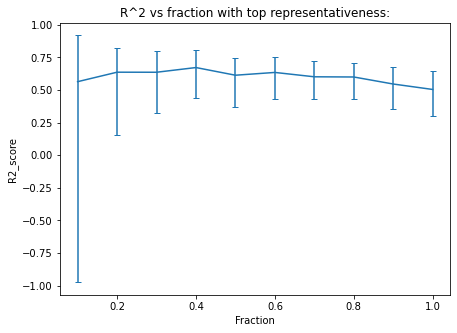

In [116]:
fog, ax = plt.subplots(1,1)
ax.errorbar(repres_vals, r2_estimators[target], 
             yerr = [r2_estimators[target] - r2_lower_CIs[target], - r2_estimators[target] + r2_upper_CIs[target]], 
             capsize= 3)
ax.set_xlabel('Fraction')
ax.set_ylabel('R2_score')
ax.set_title('R^2 vs fraction with top representativeness:')
plt.show()

# Linear model for f_energy_saturate

In [117]:
target = 'f_energy_saturate'
df_enerfy_fat = get_label_summary(target, selected_cols_best[target])
df_enerfy_fat

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1922,0.017,11.212,0.000,0.159,0.226
"Q(""Level 2 qualifications"")",-0.0875,0.021,-4.170,0.000,-0.129,-0.046
"Q(""Asian or Asian British"")",0.0467,0.017,2.681,0.008,0.012,0.081
"Q(""Sikh"")",-0.0248,0.008,-3.089,0.002,-0.041,-0.009
"Q(""Buddhist"")",-0.2713,0.073,-3.714,0.000,-0.415,-0.128
"Q(""White"")",0.0394,0.020,1.996,0.047,0.001,0.078
"Q(""Mixed"")",0.1996,0.042,4.789,0.000,0.118,0.282
"Q(""Aged 16-64"")",-0.0358,0.010,-3.450,0.001,-0.056,-0.015
"Q(""Born in UK"")",-0.0311,0.008,-3.796,0.000,-0.047,-0.015


In [118]:
selected_cols_very_best[target] = [actual_name(col) for col in list(df_enerfy_fat.index) if col != 'Intercept']
n = len(df_ward_atlas)
r2_estimators[target] = []
r2_lower_CIs[target] = []
r2_upper_CIs[target] = []
print(f'Dependence of R^2 for prediction {target} of selected fraction of areas with top representativeness:')
for repres in repres_vals:
    num_samples = int(n * repres)
    r2_scores = get_r2_samples(target, selected_cols_very_best[target], df_ward_atlas[:num_samples])
    estimator, lower_CI, upper_CI = estimate_from_samples(r2_scores)
    print(f'fraction = {repres:.1}, R^2 = {estimator:.2}, 95% CI = ({lower_CI:.2}, {upper_CI:.2})')
    r2_estimators[target].append(estimator)
    r2_lower_CIs[target].append(lower_CI)
    r2_upper_CIs[target].append(upper_CI)
r2_estimators[target] = np.array(r2_estimators[target])
r2_lower_CIs[target] = np.array(r2_lower_CIs[target])
r2_upper_CIs[target] = np.array(r2_upper_CIs[target])

Dependence of R^2 for prediction f_energy_saturate of selected fraction of areas with top representativeness:
fraction = 0.1, R^2 = 0.33, 95% CI = (-1.5, 0.76)
fraction = 0.2, R^2 = 0.49, 95% CI = (-0.27, 0.78)
fraction = 0.3, R^2 = 0.44, 95% CI = (-0.21, 0.72)
fraction = 0.4, R^2 = 0.57, 95% CI = (0.23, 0.76)
fraction = 0.5, R^2 = 0.56, 95% CI = (0.29, 0.71)
fraction = 0.6, R^2 = 0.56, 95% CI = (0.34, 0.7)
fraction = 0.7, R^2 = 0.54, 95% CI = (0.35, 0.68)
fraction = 0.8, R^2 = 0.53, 95% CI = (0.31, 0.66)
fraction = 0.9, R^2 = 0.48, 95% CI = (0.26, 0.63)
fraction = 1e+00, R^2 = 0.45, 95% CI = (0.25, 0.61)


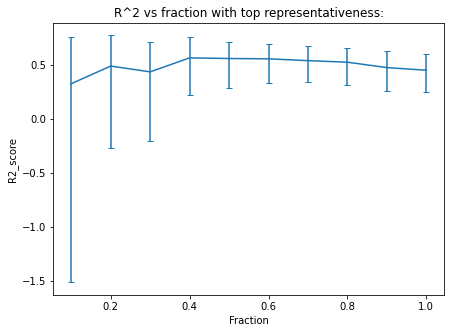

In [119]:
fog, ax = plt.subplots(1,1)
ax.errorbar(repres_vals, r2_estimators[target], 
             yerr = [r2_estimators[target] - r2_lower_CIs[target], - r2_estimators[target] + r2_upper_CIs[target]], 
             capsize= 3)
ax.set_xlabel('Fraction')
ax.set_ylabel('R2_score')
ax.set_title('R^2 vs fraction with top representativeness:')
plt.show()

# Linear model for f_energy_sugar

In [120]:
target = 'f_energy_sugar'
df_enerfy_fat = get_label_summary(target, selected_cols_best[target])
df_enerfy_fat

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1980,0.007,28.834,0.000,0.184,0.211
"Q(""Mixed"")",-0.1114,0.055,-2.025,0.044,-0.220,-0.003
"Q(""Asian or Asian British"")",0.0230,0.007,3.166,0.002,0.009,0.037
"Q(""Level 1 qualifications"")",0.2161,0.054,4.037,0.000,0.111,0.321
"Q(""IOD AVG"")",-0.0034,0.001,-3.300,0.001,-0.005,-0.001


In [121]:
selected_cols_very_best[target] = [actual_name(col) for col in list(df_enerfy_fat.index) if col != 'Intercept']
n = len(df_ward_atlas)
r2_estimators[target] = []
r2_lower_CIs[target] = []
r2_upper_CIs[target] = []
print(f'Dependence of R^2 for prediction {target} of selected fraction of areas with top representativeness:')
for repres in repres_vals:
    num_samples = int(n * repres)
    r2_scores = get_r2_samples(target, selected_cols_very_best[target], df_ward_atlas[:num_samples])
    estimator, lower_CI, upper_CI = estimate_from_samples(r2_scores)
    print(f'fraction = {repres:.1}, R^2 = {estimator:.2}, 95% CI = ({lower_CI:.2}, {upper_CI:.2})')
    r2_estimators[target].append(estimator)
    r2_lower_CIs[target].append(lower_CI)
    r2_upper_CIs[target].append(upper_CI)
r2_estimators[target] = np.array(r2_estimators[target])
r2_lower_CIs[target] = np.array(r2_lower_CIs[target])
r2_upper_CIs[target] = np.array(r2_upper_CIs[target])

Dependence of R^2 for prediction f_energy_sugar of selected fraction of areas with top representativeness:
fraction = 0.1, R^2 = 0.26, 95% CI = (-2.2, 0.74)
fraction = 0.2, R^2 = 0.34, 95% CI = (-0.28, 0.66)
fraction = 0.3, R^2 = 0.37, 95% CI = (-0.12, 0.62)
fraction = 0.4, R^2 = 0.36, 95% CI = (0.031, 0.57)
fraction = 0.5, R^2 = 0.34, 95% CI = (0.065, 0.53)
fraction = 0.6, R^2 = 0.32, 95% CI = (0.071, 0.49)
fraction = 0.7, R^2 = 0.34, 95% CI = (0.12, 0.49)
fraction = 0.8, R^2 = 0.39, 95% CI = (0.2, 0.52)
fraction = 0.9, R^2 = 0.4, 95% CI = (0.25, 0.56)
fraction = 1e+00, R^2 = 0.41, 95% CI = (0.27, 0.55)


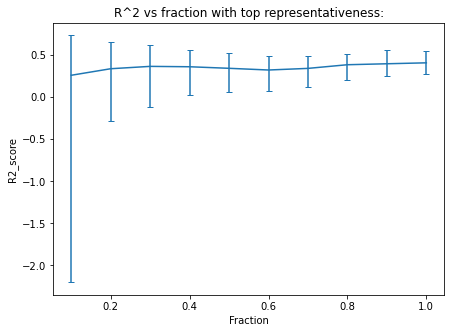

In [122]:
fog, ax = plt.subplots(1,1)
ax.errorbar(repres_vals, r2_estimators[target], 
             yerr = [r2_estimators[target] - r2_lower_CIs[target], - r2_estimators[target] + r2_upper_CIs[target]], 
             capsize= 3)
ax.set_xlabel('Fraction')
ax.set_ylabel('R2_score')
ax.set_title('R^2 vs fraction with top representativeness:')
plt.show()

# Linear model for f_energy_protein

In [123]:
target = 'f_energy_protein'
df_enerfy_fat = get_label_summary(target, selected_cols_best[target])
df_enerfy_fat

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1218,0.018,6.923,0.000,0.087,0.156
"Q(""Asian or Asian British"")",-0.0492,0.014,-3.610,0.000,-0.076,-0.022
"Q(""Sikh"")",0.0463,0.010,4.738,0.000,0.027,0.066
"Q(""Aged 0-15"")",-0.0271,0.010,-2.750,0.006,-0.046,-0.008
"Q(""No religion"")",-0.0278,0.008,-3.438,0.001,-0.044,-0.012
"Q(""Mixed"")",0.1137,0.037,3.075,0.002,0.041,0.186
"Q(""Muslim"")",0.0220,0.009,2.348,0.019,0.004,0.041
"Q(""Hindu"")",0.0348,0.011,3.046,0.002,0.012,0.057


In [124]:
selected_cols_very_best[target] = [actual_name(col) for col in list(df_enerfy_fat.index) if col != 'Intercept']
n = len(df_ward_atlas)
r2_estimators[target] = []
r2_lower_CIs[target] = []
r2_upper_CIs[target] = []
print(f'Dependence of R^2 for prediction {target} of selected fraction of areas with top representativeness:')
for repres in repres_vals:
    num_samples = int(n * repres)
    r2_scores = get_r2_samples(target, selected_cols_very_best[target], df_ward_atlas[:num_samples])
    estimator, lower_CI, upper_CI = estimate_from_samples(r2_scores)
    print(f'fraction = {repres:.1}, R^2 = {estimator:.2}, 95% CI = ({lower_CI:.2}, {upper_CI:.2})')
    r2_estimators[target].append(estimator)
    r2_lower_CIs[target].append(lower_CI)
    r2_upper_CIs[target].append(upper_CI)
r2_estimators[target] = np.array(r2_estimators[target])
r2_lower_CIs[target] = np.array(r2_lower_CIs[target])
r2_upper_CIs[target] = np.array(r2_upper_CIs[target])

Dependence of R^2 for prediction f_energy_protein of selected fraction of areas with top representativeness:
fraction = 0.1, R^2 = 0.86, 95% CI = (0.29, 0.95)
fraction = 0.2, R^2 = 0.8, 95% CI = (0.3, 0.93)
fraction = 0.3, R^2 = 0.76, 95% CI = (0.43, 0.89)
fraction = 0.4, R^2 = 0.77, 95% CI = (0.49, 0.87)
fraction = 0.5, R^2 = 0.74, 95% CI = (0.41, 0.85)
fraction = 0.6, R^2 = 0.69, 95% CI = (0.45, 0.81)
fraction = 0.7, R^2 = 0.63, 95% CI = (0.38, 0.76)
fraction = 0.8, R^2 = 0.58, 95% CI = (0.39, 0.71)
fraction = 0.9, R^2 = 0.56, 95% CI = (0.39, 0.69)
fraction = 1e+00, R^2 = 0.55, 95% CI = (0.4, 0.67)


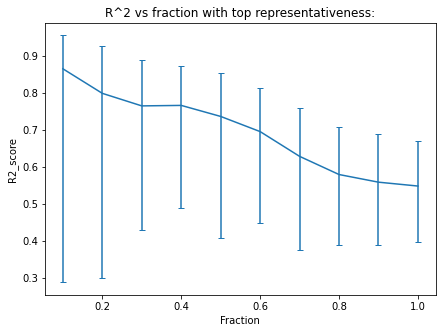

In [125]:
fog, ax = plt.subplots(1,1)
ax.errorbar(repres_vals, r2_estimators[target], 
             yerr = [r2_estimators[target] - r2_lower_CIs[target], - r2_estimators[target] + r2_upper_CIs[target]], 
             capsize= 3)
ax.set_xlabel('Fraction')
ax.set_ylabel('R2_score')
ax.set_title('R^2 vs fraction with top representativeness:')
plt.show()

# Linear model for f_energy_carb

In [126]:
target = 'f_energy_carb'
df_enerfy_fat = get_label_summary(target, selected_cols_best[target])
df_enerfy_fat

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.3990,0.012,34.298,0.000,0.376,0.422
"Q(""Level 2 qualifications"")",0.2072,0.056,3.712,0.000,0.097,0.317
"Q(""White"")",-0.0732,0.012,-6.272,0.000,-0.096,-0.050
"Q(""Mixed"")",-0.3069,0.068,-4.543,0.000,-0.440,-0.174
"Q(""Born in UK"")",0.0447,0.012,3.803,0.000,0.022,0.068
"Q(""Sikh"")",-0.0453,0.014,-3.320,0.001,-0.072,-0.018


In [127]:
selected_cols_very_best[target] = [actual_name(col) for col in list(df_enerfy_fat.index) if col != 'Intercept']
n = len(df_ward_atlas)
r2_estimators[target] = []
r2_lower_CIs[target] = []
r2_upper_CIs[target] = []
print(f'Dependence of R^2 for prediction {target} of selected fraction of areas with top representativeness:')
for repres in repres_vals:
    num_samples = int(n * repres)
    r2_scores = get_r2_samples(target, selected_cols_very_best[target], df_ward_atlas[:num_samples])
    estimator, lower_CI, upper_CI = estimate_from_samples(r2_scores)
    print(f'fraction = {repres:.1}, R^2 = {estimator:.2}, 95% CI = ({lower_CI:.2}, {upper_CI:.2})')
    r2_estimators[target].append(estimator)
    r2_lower_CIs[target].append(lower_CI)
    r2_upper_CIs[target].append(upper_CI)
r2_estimators[target] = np.array(r2_estimators[target])
r2_lower_CIs[target] = np.array(r2_lower_CIs[target])
r2_upper_CIs[target] = np.array(r2_upper_CIs[target])

Dependence of R^2 for prediction f_energy_carb of selected fraction of areas with top representativeness:
fraction = 0.1, R^2 = 0.76, 95% CI = (-0.24, 0.95)
fraction = 0.2, R^2 = 0.77, 95% CI = (0.37, 0.88)
fraction = 0.3, R^2 = 0.81, 95% CI = (0.65, 0.9)
fraction = 0.4, R^2 = 0.82, 95% CI = (0.7, 0.9)
fraction = 0.5, R^2 = 0.8, 95% CI = (0.66, 0.88)
fraction = 0.6, R^2 = 0.79, 95% CI = (0.66, 0.86)
fraction = 0.7, R^2 = 0.76, 95% CI = (0.66, 0.84)
fraction = 0.8, R^2 = 0.76, 95% CI = (0.66, 0.83)
fraction = 0.9, R^2 = 0.76, 95% CI = (0.66, 0.82)
fraction = 1e+00, R^2 = 0.74, 95% CI = (0.64, 0.81)


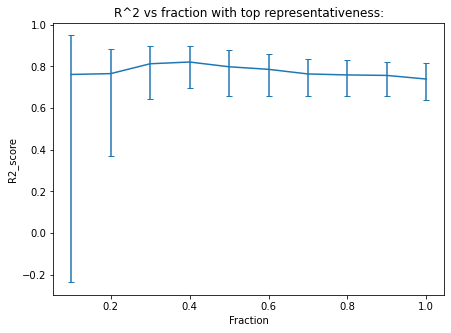

In [128]:
fog, ax = plt.subplots(1,1)
ax.errorbar(repres_vals, r2_estimators[target], 
             yerr = [r2_estimators[target] - r2_lower_CIs[target], - r2_estimators[target] + r2_upper_CIs[target]], 
             capsize= 3)
ax.set_xlabel('Fraction')
ax.set_ylabel('R2_score')
ax.set_title('R^2 vs fraction with top representativeness:')
plt.show()

# Linear model for f_energy_fibre

In [129]:
target = 'f_energy_fibre'
df_enerfy_fat = get_label_summary(target, selected_cols_best[target])
df_enerfy_fat

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0178,0.001,32.477,0.000,0.017000,0.019
"Q(""No qualifications"")",-0.0061,0.002,-3.731,0.000,-0.009000,-0.003
"Q(""Jewish"")",0.0062,0.001,7.829,0.000,0.005000,0.008
"Q(""White"")",0.0009,0.000,2.133,0.034,0.000071,0.002
"Q(""Sikh"")",0.0060,0.001,6.940,0.000,0.004000,0.008
"Q(""Level 1 qualifications"")",-0.0144,0.003,-4.954,0.000,-0.020000,-0.009
"Q(""Asian or Asian British"")",-0.0022,0.001,-3.547,0.000,-0.003000,-0.001
"Q(""Buddhist"")",0.0170,0.007,2.509,0.013,0.004000,0.030


In [130]:
selected_cols_very_best[target] = [actual_name(col) for col in list(df_enerfy_fat.index) if col != 'Intercept']
n = len(df_ward_atlas)
r2_estimators[target] = []
r2_lower_CIs[target] = []
r2_upper_CIs[target] = []
print(f'Dependence of R^2 for prediction {target} of selected fraction of areas with top representativeness:')
for repres in repres_vals:
    num_samples = int(n * repres)
    r2_scores = get_r2_samples(target, selected_cols_very_best[target], df_ward_atlas[:num_samples])
    estimator, lower_CI, upper_CI = estimate_from_samples(r2_scores)
    print(f'fraction = {repres:.1}, R^2 = {estimator:.2}, 95% CI = ({lower_CI:.2}, {upper_CI:.2})')
    r2_estimators[target].append(estimator)
    r2_lower_CIs[target].append(lower_CI)
    r2_upper_CIs[target].append(upper_CI)
r2_estimators[target] = np.array(r2_estimators[target])
r2_lower_CIs[target] = np.array(r2_lower_CIs[target])
r2_upper_CIs[target] = np.array(r2_upper_CIs[target])

Dependence of R^2 for prediction f_energy_fibre of selected fraction of areas with top representativeness:
fraction = 0.1, R^2 = 0.75, 95% CI = (0.15, 0.92)
fraction = 0.2, R^2 = 0.8, 95% CI = (0.49, 0.91)
fraction = 0.3, R^2 = 0.8, 95% CI = (0.6, 0.9)
fraction = 0.4, R^2 = 0.8, 95% CI = (0.59, 0.89)
fraction = 0.5, R^2 = 0.78, 95% CI = (0.59, 0.88)
fraction = 0.6, R^2 = 0.78, 95% CI = (0.63, 0.87)
fraction = 0.7, R^2 = 0.79, 95% CI = (0.66, 0.87)
fraction = 0.8, R^2 = 0.78, 95% CI = (0.68, 0.86)
fraction = 0.9, R^2 = 0.78, 95% CI = (0.67, 0.86)
fraction = 1e+00, R^2 = 0.75, 95% CI = (0.65, 0.84)


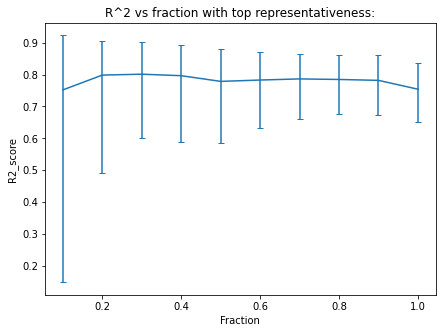

In [131]:
fog, ax = plt.subplots(1,1)
ax.errorbar(repres_vals, r2_estimators[target], 
             yerr = [r2_estimators[target] - r2_lower_CIs[target], - r2_estimators[target] + r2_upper_CIs[target]], 
             capsize= 3)
ax.set_xlabel('Fraction')
ax.set_ylabel('R2_score')
ax.set_title('R^2 vs fraction with top representativeness:')
plt.show()

# Linear model for f_energy_alcohol

In [132]:
target = 'f_energy_alcohol'
df_enerfy_fat = get_label_summary(target, selected_cols_best[target])
df_enerfy_fat

,coef,std err,t,P>|t|,[0.025,0.975]
"Q(""Level >=4 qualifications"")",0.0094,0.001,9.665,0.000,0.008,0.011
"Q(""Asian or Asian British"")",0.0072,0.002,2.902,0.004,0.002,0.012
"Q(""Muslim"")",-0.0059,0.002,-3.126,0.002,-0.010,-0.002
"Q(""IOD AVG"")",0.0005,0.000,3.072,0.002,0.000,0.001
"Q(""Mixed"")",0.0406,0.012,3.265,0.001,0.016,0.065
"Q(""White"")",0.0057,0.002,2.790,0.006,0.002,0.010
"Q(""Christian"")",0.0045,0.002,2.822,0.005,0.001,0.008


In [133]:
selected_cols_very_best[target] = [actual_name(col) for col in list(df_enerfy_fat.index) if col != 'Intercept']
n = len(df_ward_atlas)
r2_estimators[target] = []
r2_lower_CIs[target] = []
r2_upper_CIs[target] = []
print(f'Dependence of R^2 for prediction {target} of selected fraction of areas with top representativeness:')
for repres in repres_vals:
    num_samples = int(n * repres)
    r2_scores = get_r2_samples(target, selected_cols_very_best[target], df_ward_atlas[:num_samples])
    estimator, lower_CI, upper_CI = estimate_from_samples(r2_scores)
    print(f'fraction = {repres:.1}, R^2 = {estimator:.2}, 95% CI = ({lower_CI:.2}, {upper_CI:.2})')
    r2_estimators[target].append(estimator)
    r2_lower_CIs[target].append(lower_CI)
    r2_upper_CIs[target].append(upper_CI)
r2_estimators[target] = np.array(r2_estimators[target])
r2_lower_CIs[target] = np.array(r2_lower_CIs[target])
r2_upper_CIs[target] = np.array(r2_upper_CIs[target])

Dependence of R^2 for prediction f_energy_alcohol of selected fraction of areas with top representativeness:
fraction = 0.1, R^2 = 0.36, 95% CI = (-2.0, 0.85)
fraction = 0.2, R^2 = 0.68, 95% CI = (-0.085, 0.89)
fraction = 0.3, R^2 = 0.62, 95% CI = (0.18, 0.84)
fraction = 0.4, R^2 = 0.63, 95% CI = (0.29, 0.8)
fraction = 0.5, R^2 = 0.63, 95% CI = (0.32, 0.78)
fraction = 0.6, R^2 = 0.57, 95% CI = (0.29, 0.74)
fraction = 0.7, R^2 = 0.54, 95% CI = (0.33, 0.69)
fraction = 0.8, R^2 = 0.51, 95% CI = (0.27, 0.65)
fraction = 0.9, R^2 = 0.5, 95% CI = (0.31, 0.63)
fraction = 1e+00, R^2 = 0.45, 95% CI = (0.27, 0.58)


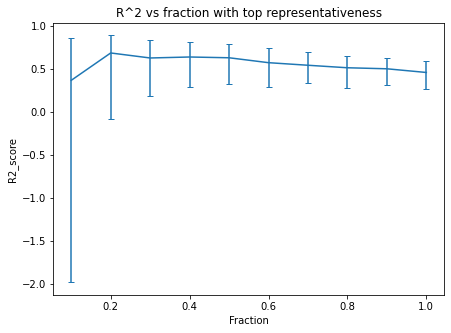

In [134]:
fog, ax = plt.subplots(1,1)
ax.errorbar(repres_vals, r2_estimators[target], 
             yerr = [r2_estimators[target] - r2_lower_CIs[target], - r2_estimators[target] + r2_upper_CIs[target]], 
             capsize= 3)
ax.set_xlabel('Fraction')
ax.set_ylabel('R2_score')
ax.set_title('R^2 vs fraction with top representativeness')
plt.show()

# Linear model for energy_tot

In [176]:
target = 'energy_tot'
df_enerfy_fat = get_label_summary(target, selected_cols_best[target])
df_enerfy_fat

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,149.2673,13.656,10.931,0.000,122.418,176.117
"Q(""Jewish"")",-45.1398,6.296,-7.170,0.000,-57.518,-32.762
"Q(""Mixed"")",-126.7347,27.057,-4.684,0.000,-179.933,-73.536
"Q(""Born in UK"")",17.0488,4.769,3.575,0.000,7.673,26.425
"Q(""Muslim"")",13.1911,5.356,2.463,0.014,2.660,23.722


In [177]:
selected_cols_very_best[target] = [actual_name(col) for col in list(df_enerfy_fat.index) if col != 'Intercept']
n = len(df_ward_atlas)
r2_estimators[target] = []
r2_lower_CIs[target] = []
r2_upper_CIs[target] = []
print(f'Dependence of R^2 for prediction {target} of selected fraction of areas with top representativeness:')
for repres in repres_vals:
    num_samples = int(n * repres)
    r2_scores = get_r2_samples(target, selected_cols_very_best[target], df_ward_atlas[:num_samples])
    estimator, lower_CI, upper_CI = estimate_from_samples(r2_scores)
    print(f'fraction = {repres:.1}, R^2 = {estimator:.2}, 95% CI = ({lower_CI:.2}, {upper_CI:.2})')
    r2_estimators[target].append(estimator)
    r2_lower_CIs[target].append(lower_CI)
    r2_upper_CIs[target].append(upper_CI)
r2_estimators[target] = np.array(r2_estimators[target])
r2_lower_CIs[target] = np.array(r2_lower_CIs[target])
r2_upper_CIs[target] = np.array(r2_upper_CIs[target])

Dependence of R^2 for prediction energy_tot of selected fraction of areas with top representativeness:
fraction = 0.1, R^2 = 0.5, 95% CI = (-1.7, 0.86)
fraction = 0.2, R^2 = 0.64, 95% CI = (-0.24, 0.86)
fraction = 0.3, R^2 = 0.57, 95% CI = (0.13, 0.78)
fraction = 0.4, R^2 = 0.5, 95% CI = (0.15, 0.72)
fraction = 0.5, R^2 = 0.51, 95% CI = (0.2, 0.69)
fraction = 0.6, R^2 = 0.47, 95% CI = (0.24, 0.65)
fraction = 0.7, R^2 = 0.48, 95% CI = (0.27, 0.64)
fraction = 0.8, R^2 = 0.5, 95% CI = (0.3, 0.63)
fraction = 0.9, R^2 = 0.51, 95% CI = (0.3, 0.64)
fraction = 1e+00, R^2 = 0.49, 95% CI = (0.3, 0.61)


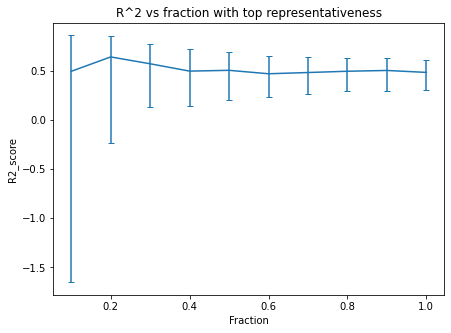

In [178]:
fog, ax = plt.subplots(1,1)
ax.errorbar(repres_vals, r2_estimators[target], 
             yerr = [r2_estimators[target] - r2_lower_CIs[target], - r2_estimators[target] + r2_upper_CIs[target]], 
             capsize= 3)
ax.set_xlabel('Fraction')
ax.set_ylabel('R2_score')
ax.set_title('R^2 vs fraction with top representativeness')
plt.show()

# Linear models for all

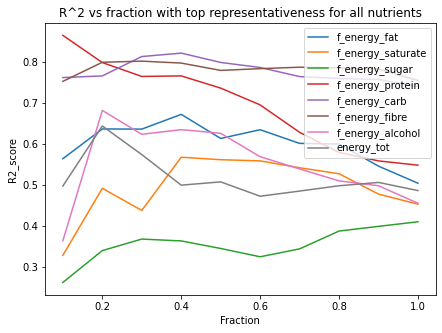

In [179]:
fog, ax = plt.subplots(1,1)
for nutrient in r2_estimators.keys():
    ax.plot(repres_vals, r2_estimators[nutrient], label=nutrient)
ax.set_xlabel('Fraction')
ax.set_ylabel('R2_score')
ax.set_title(f'R^2 vs fraction with top representativeness for all nutrients')
ax.legend()
plt.show()

From the plot we see that R^2 do not generally improves as we take areas with top representativeness. Only for F_energy protein it is clearly the case.

# Neural Network for predicting all at once

In [162]:
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import KLDivergence
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [143]:
target_cols = ['f_energy_fat', 'f_energy_protein', 'f_energy_carb', 'f_energy_fibre', 'f_energy_alcohol']

In [144]:
any(np.abs(df_ward_atlas[target_cols].sum(axis=1) - 1 > 0.01))

False

In [156]:
model = Sequential()
model.add(Input(shape=(30,)))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='sgd', 
              loss=KLDivergence(), 
              metrics=['mean_absolute_error'])

In [157]:
x_data = df_ward_atlas[all_features]
y_data = df_ward_atlas[target_cols]
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2)

In [158]:
history = model.fit(x_train, y_train, epochs=500, verbose=0)

In [161]:
nn_preds = model.predict(x_test)

In [174]:
print('R2 score of neural network for predicting each nutrient:')
for i, target in enumerate(target_cols):
    r2_nn = r2_score(y_test[target], nn_preds[:,i])
    print(f'{target}: {r2_nn:.2}')

R2 score of neural network for predicting each nutrient:
f_energy_fat: -4.9
f_energy_protein: -2.4
f_energy_carb: -0.6
f_energy_fibre: -2.7e+01
f_energy_alcohol: -1.8


We see that neural network, when tries to predict all nutrients simultaniously, performs poorly for each individual nutrient prediction